# Text Classification- Traffic Violation Data

In this notebook, I have built a classifier to classify traffic violations into 3 main categories- "Warning", "Citation", "ESERO".

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np


import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [2]:
directory=os.getcwd()
file=directory+"/md_traffic_10K.csv"

In [3]:
data=pd.read_table(file, skiprows=1, header=None, sep=',', names=['description', 'violation'])

In [4]:
data.head()

,description,violation
0,DRIVER FAILURE TO STOP AT STEADY CIRCULAR RED ...,Citation
1,HEADLIGHTS (*),ESERO
2,FAILURE TO DISPLAY TWO LIGHTED FRONT LAMPS WHE...,Warning
3,DRIVER FAILURE TO STOP AT STOP SIGN LINE,Warning
4,STOP LIGHTS (*),ESERO


# Explore the data to understand the different types of violations and it's properties

In [5]:
#identify the types and percentage of violations
data['violation'].value_counts(normalize=True)

Warning     0.479348
Citation    0.453745
ESERO       0.066907
Name: violation, dtype: float64

In [6]:
data['description'][data['violation']=='Warning']

2       FAILURE TO DISPLAY TWO LIGHTED FRONT LAMPS WHE...
3                DRIVER FAILURE TO STOP AT STOP SIGN LINE
12      FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...
13                                  STOPLIGHT INOPERATIVE
14      FAILURE TO PROPERLY EQUIP & LOCATE HEADLAMPS O...
                              ...                        
9984    FAILURE OF DR. TO MAKE LANE CHANGE TO AVAIL. L...
9992    FAILURE TO ATTACH VEHICLE REGISTRATION PLATES ...
9995           EXCEEDING THE POSTED SPEED LIMIT OF 40 MPH
9996    FAILURE TO DISPLAY TWO LIGHTED FRONT LAMPS WHE...
9998    DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...
Name: description, Length: 4793, dtype: object

In [7]:
data['description'][data['violation']=='Citation']

0       DRIVER FAILURE TO STOP AT STEADY CIRCULAR RED ...
5       DRIVING  MOTOR VEHICLE ON HIGHWAY WITHOUT REQU...
6       DRIVING VEHICLE ON HIGHWAY WITH AN EXPIRED LIC...
7       FAILURE OF INDIVIDUAL DRIVING ON HIGHWAY TO DI...
8       FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...
                              ...                        
9988                    DRIVING WHILE IMPAIRED BY ALCOHOL
9989    FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...
9990    DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...
9993    OPERATING VEHICLE ON HIGHWAY WITH UNAUTHORIZED...
9994    OPERATING VEHICLE ON HIGHWAY WITH UNAUTHORIZED...
Name: description, Length: 4537, dtype: object

In [8]:
data['description'][data['violation']=='ESERO']

1        HEADLIGHTS (*)
4       STOP LIGHTS (*)
54       TAILLIGHTS (*)
55       TAG LIGHTS (*)
56       HEADLIGHTS (*)
             ...       
9903        WINDOW TINT
9951    STOP LIGHTS (*)
9982    STOP LIGHTS (*)
9991        WINDOW TINT
9997     HEADLIGHTS (*)
Name: description, Length: 669, dtype: object

In [9]:
#analyze violations based on character size of the text
data['Length']=data['description'].apply(len)

In [10]:
data.describe(include="all")

,description,violation,Length
count,9999,9999,9999.000000
unique,751,3,NaN
top,DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...,Warning,NaN
freq,702,4793,NaN
mean,NaN,NaN,59.869987
std,NaN,NaN,22.101529
min,NaN,NaN,5.000000
25%,NaN,NaN,46.000000
50%,NaN,NaN,59.000000
75%,NaN,NaN,76.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a27f9c450>,
      dtype=object)

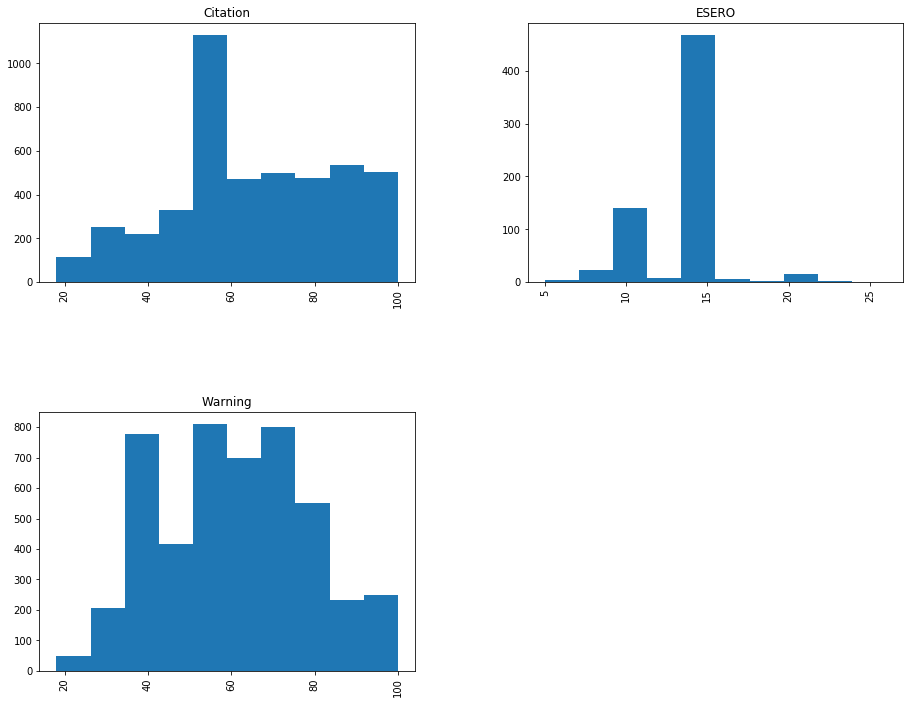

In [11]:
#histogram of the different kinds of violations and the associate character size
data.hist(column="Length",by="violation",figsize=(15,12))

Length of characters vary based on the type of violation:
    1. Citation has a mean length of around 60
    2. ESERO has 10-15 characters
    3. Warning has varied length of characters

# Data preprocessing

__Clean the text data__

This function takes in the text and removes punctuations, stop words and lemmatizes the words

In [12]:
#function to clean the text data
def text_clean(text):
    """ Clean the text data.

    Args:
        text (string): description
    """ 
    no_punc_text=[i for i in text if i not in string.punctuation] #remove punctuations
    no_punc_text=''.join(no_punc_text)
    no_stop_text=[i for i in no_punc_text.split() if i.lower() not in stopwords.words('english')] #remove stopwords
    #no_stop_text=' '.join(no_punc_text)
    normalized =  ' '.join(lemma.lemmatize(word) for word in no_stop_text)#lemmatize
    return normalized.split()

__Create pipeline to clean the data, calculate TF-IDF scores, fit a classification model__

In [13]:
#pipeline to obtain a TF-IDF matrix and fit classifiers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

#Multinomial Naive Bayes
text_clf_nb = Pipeline([('vect', CountVectorizer(tokenizer=text_clean)),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

#SVD
text_clf_svm = Pipeline([('vect', CountVectorizer(tokenizer=text_clean)),('tfidf', TfidfTransformer()),('clf', SGDClassifier()),])

__Further processing of the data to fit the models__

In [14]:
#split data into train and test
from sklearn.model_selection import train_test_split

#replace violations to numeric values and create X and Y sets
data['violation'].replace({'Warning':"1","Citation":"2","ESERO":"3"},inplace=True)
X=data['description']
y=data['violation']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [15]:
y_train.value_counts(normalize=True)

1    0.479264
2    0.452327
3    0.068409
Name: violation, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

1    0.4796
2    0.4580
3    0.0624
Name: violation, dtype: float64

In [17]:
print("Length of test data:",len(X_test))
print("Length of train data:",len(X_train))

Length of test data: 2500
Length of train data: 7499


__Grid Search to search for the best parameters__

In [18]:
#grid search to obtain best parameters for the model
from sklearn.model_selection import GridSearchCV

1. Naive Bayes- Find the best parameters for count vectorizer, tfidf

In [21]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False)}

#fit model for Naive Bayes classifier
gs_clf_nb = GridSearchCV(text_clf_nb, parameters, n_jobs=-1)
gs_clf_nb = gs_clf_nb.fit(X_train, y_train)

In [22]:
#best score and params for Naive Bayes
print("Naive Bayes: Best Score:",gs_clf_nb.best_score_)
print("Naive Bayes: Best Params:", gs_clf_nb.best_params_)

Naive Bayes: Best Score: 0.7670361574382922
Naive Bayes: Best Params: {'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


2. SVD- Find the best parameters for count vectorizer, tfidf

In [23]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False)}

#fit model for SVM classifier
gs_clf_svm = GridSearchCV(text_clf_svm, parameters, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)

In [24]:
#best score and params for SVM
print("SVM: Best Score:",gs_clf_svm.best_score_)
print("SVM: Best Params:", gs_clf_svm.best_params_)

SVM: Best Score: 0.7773038025350234
SVM: Best Params: {'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


# __Validate models against test data__

In [25]:
#validate against test data

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve

In [ ]:
"""
Don't run this function. sklearn v 0.22 onwards has an in-built function to plot confusion matrix

#function to plot the heatmap of the confusion matrix
def func_plot_confusion_matrix(cm, normalize=False):
    """ Plot the confusion matrix as a heatmap.

    Args:
        cm (numpy ndarray): confusion matrix
        normalize (bool): whether to plot the normalized confusion matrix
        
    """  
    # Plot non-normalized confusion matrix
    plt.figure()
    
    classes = ['Warning', 'Citation','ESERO']
    
    _plot_confusion_matrix(cm,classes=classes,
                          title='Confusion matrix, without normalization')
    
    if normalize:
        # Plot normalized confusion matrix
        plt.figure()
        _plot_confusion_matrix(cm, normalize=True,classes=classes,
                              title='Normalized confusion matrix')

    plt.show()

def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
"""

__Validate Naive Bayes__

In [26]:
#NB validation

#fit best Naive Bayes model
text_clf_nb_best = Pipeline([('vect', CountVectorizer(tokenizer=text_clean,ngram_range=(1, 1))),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
text_clf_nb_best=text_clf_nb_best.fit(X_train,y_train)

In [27]:
#predict classes on test set
pred_nb = text_clf_nb_best.predict(X_test)

In [28]:
#calculate predicted probabilities
pred_nb_prob=text_clf_nb_best.predict_proba(X_test)

In [29]:
print("Classification Report for the Naive Bayes Classifier")
print(classification_report(y_test,pred_nb))

Classification Report for the Naive Bayes Classifier
              precision    recall  f1-score   support

           1       0.71      0.80      0.75      1199
           2       0.76      0.66      0.71      1145
           3       0.96      0.94      0.95       156

    accuracy                           0.75      2500
   macro avg       0.81      0.80      0.80      2500
weighted avg       0.75      0.75      0.75      2500



In [30]:
print("Confusion Matrix for the Naive Bayes Classifier")
confusion_matrix(y_test, pred_nb, labels=['1', '2', '3'])

Confusion Matrix for the Naive Bayes Classifier


array([[962, 234,   3],
       [382, 760,   3],
       [ 10,   0, 146]])

Confusion matrix, without normalization
[[962 234   3]
 [382 760   3]
 [ 10   0 146]]
Normalized confusion matrix
[[0.8  0.2  0.  ]
 [0.33 0.66 0.  ]
 [0.06 0.   0.94]]


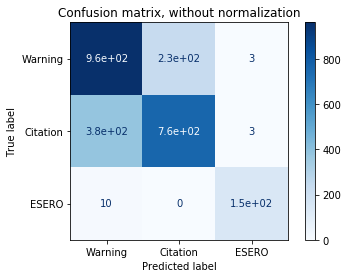

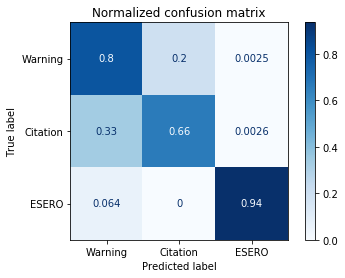

In [36]:
np.set_printoptions(precision=2)
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names=["Warning","Citation","ESERO"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_clf_nb_best, X_test, y_test,display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

__Validate SVM__

In [37]:
#SVM validation

#fit best SVM model
text_clf_svm_best = Pipeline([('vect', CountVectorizer(tokenizer=text_clean,ngram_range=(1, 2))),('tfidf', TfidfTransformer()),('clf', SGDClassifier())])
text_clf_svm_best=text_clf_svm_best.fit(X_train,y_train)

In [38]:
#predict classes on test data
pred_svm = text_clf_svm_best.predict(X_test)

In [39]:
print("Classification Report for the SVM Classifier")
print(classification_report(y_test,pred_svm))

Classification Report for the SVM Classifier
              precision    recall  f1-score   support

           1       0.69      0.87      0.77      1199
           2       0.82      0.60      0.69      1145
           3       0.99      0.96      0.97       156

    accuracy                           0.75      2500
   macro avg       0.83      0.81      0.81      2500
weighted avg       0.77      0.75      0.75      2500



In [40]:
print("Confusion Matrix for the SVM Classifier")
confusion_matrix(y_test, pred_svm, labels=['1', '2', '3'])

Confusion Matrix for the SVM Classifier


array([[1042,  156,    1],
       [ 456,  689,    0],
       [   7,    0,  149]])

Confusion matrix, without normalization
[[1042  156    1]
 [ 456  689    0]
 [   7    0  149]]
Normalized confusion matrix
[[8.69e-01 1.30e-01 8.34e-04]
 [3.98e-01 6.02e-01 0.00e+00]
 [4.49e-02 0.00e+00 9.55e-01]]


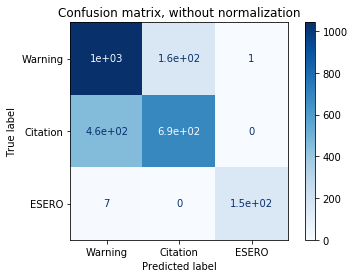

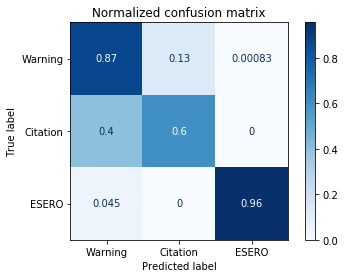

In [42]:
np.set_printoptions(precision=2)
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names=["Warning","Citation","ESERO"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_clf_svm_best, X_test, y_test,display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Both Naive Bayes and SVM have similar accuracy scores. But SVM has a slightly higher precision- it has a higher true positive rate.

But in both the models we see that "Citations" have been falsely classified as "Warnings" in ~30% of the times. Further analysis and cleaning the "Citations" might improve the accuracy further.